In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('/home/husein/space/Stock-Prediction-Comparison/dataset/GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [4]:
class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias = 0.1,
                attention_size = 10):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units = size_layer, 
                                                                    memory = self.X)
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], 
                                                                                           state_is_tuple = False), 
                                                        attention_mechanism = attention_mechanism,
                                                        attention_layer_size = size_layer)   
        drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)
        self.outputs, _ = tf.nn.dynamic_rnn(drop, self.X, dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [5]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 50

In [6]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        _, loss = sess.run([modelnn.optimizer, modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y})
        total_loss += loss
    total_loss /= (df_log.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.006239589615724981
epoch: 200 avg loss: 0.0050499271356966345
epoch: 300 avg loss: 0.005205073960823938
epoch: 400 avg loss: 0.006463312606792897
epoch: 500 avg loss: 0.007061200940515846


In [7]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(modelnn.logits, feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0)})
    output_predict[k + 1: k + timestamp + 1, :] = out_logits
    
out_logits = sess.run(modelnn.logits, feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[upper_b: , :], axis = 0)})
output_predict[upper_b + 1: df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1]+timedelta(days=1))

In [8]:
for i in range(future_day - 1):
    out_logits = sess.run(modelnn.logits, feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0)})
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1]+timedelta(days=1))

In [9]:
df_log = minmax.inverse_transform(output_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

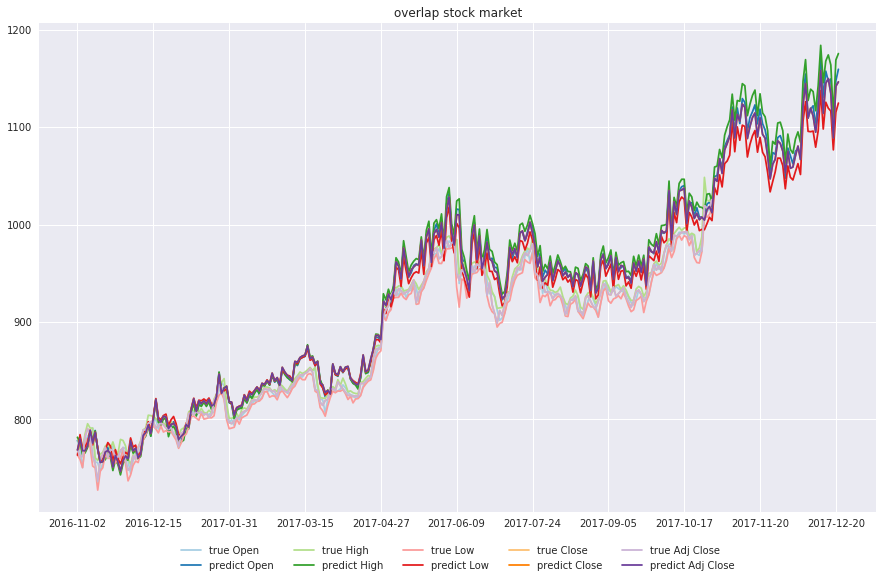

In [10]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(x_range_original, df.iloc[:, 1], label = 'true Open', color = current_palette[0])
ax.plot(x_range_future, df_log[:, 0], label = 'predict Open', color = current_palette[1])
ax.plot(x_range_original, df.iloc[:, 2], label = 'true High', color = current_palette[2])
ax.plot(x_range_future, df_log[:, 1], label = 'predict High', color = current_palette[3])
ax.plot(x_range_original, df.iloc[:, 3], label = 'true Low', color = current_palette[4])
ax.plot(x_range_future, df_log[:, 2], label = 'predict Low', color = current_palette[5])
ax.plot(x_range_original, df.iloc[:, 4], label = 'true Close', color = current_palette[6])
ax.plot(x_range_future, df_log[:, 3], label = 'predict Close', color = current_palette[7])
ax.plot(x_range_original, df.iloc[:, 5], label = 'true Adj Close', color = current_palette[8])
ax.plot(x_range_future, df_log[:, 4], label = 'predict Adj Close', color = current_palette[9])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

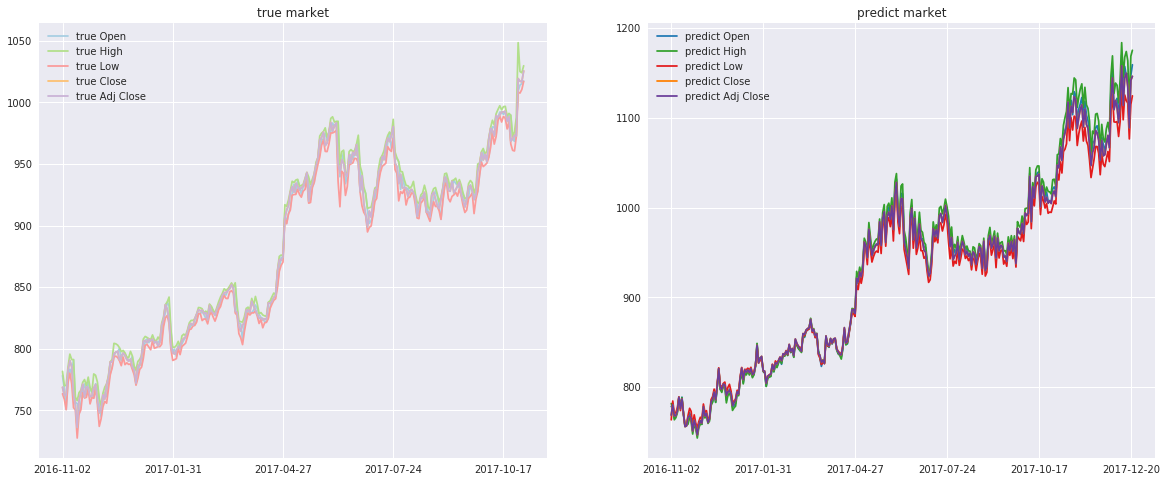

In [11]:
fig = plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, 1], label = 'true Open', color = current_palette[0])
plt.plot(x_range_original, df.iloc[:, 2], label = 'true High', color = current_palette[2])
plt.plot(x_range_original, df.iloc[:, 3], label = 'true Low', color = current_palette[4])
plt.plot(x_range_original, df.iloc[:, 4], label = 'true Close', color = current_palette[6])
plt.plot(x_range_original, df.iloc[:, 5], label = 'true Adj Close', color = current_palette[8])
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, df_log[:, 0], label = 'predict Open', color = current_palette[1])
plt.plot(x_range_future, df_log[:, 1], label = 'predict High', color = current_palette[3])
plt.plot(x_range_future, df_log[:, 2], label = 'predict Low', color = current_palette[5])
plt.plot(x_range_future, df_log[:, 3], label = 'predict Close', color = current_palette[7])
plt.plot(x_range_future, df_log[:, 4], label = 'predict Adj Close', color = current_palette[9])
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

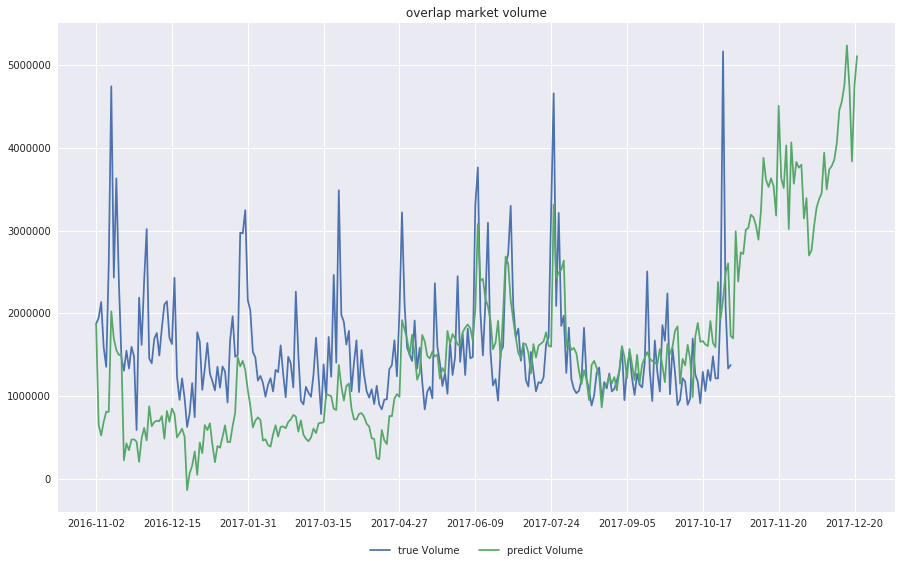

In [12]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

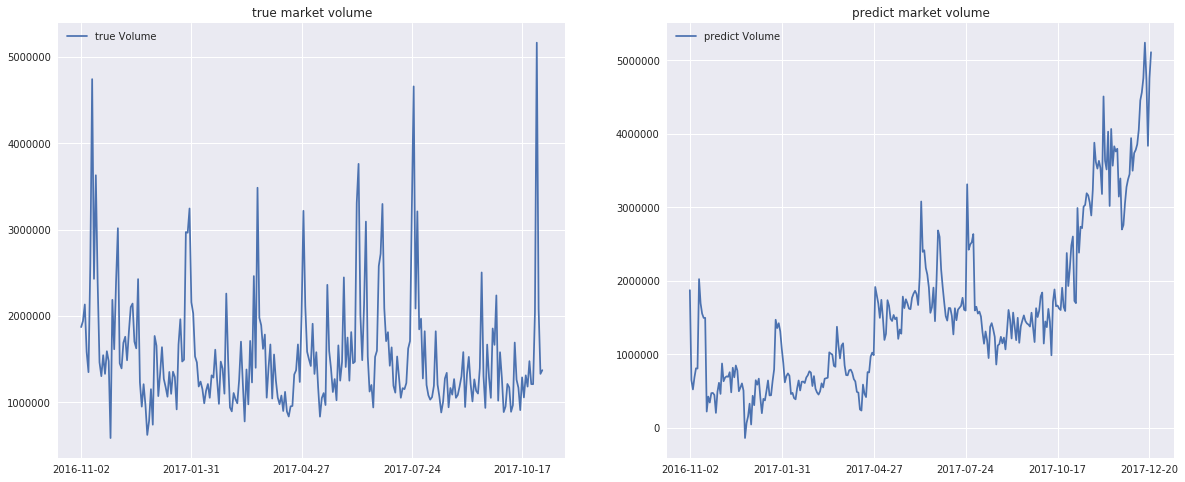

In [13]:
fig = plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()